In [1]:
# a) Import required libraries

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, losses, metrics

print("Imports complete!")

Imports complete!



In [2]:
# b) Upload / access the dataset

with np.load(r"C:\Users\kusha\Desktop\mnist_dataset.npz") as data:
    x_train_all = data["X_train"]
    y_train_all = data["y_train"]
    x_test_all  = data["X_test"]
    y_test_all  = data["y_test"]

print(
    f"x_train_all:\n"
    f"  Data type: {x_train_all.dtype}\n"
    f"  Shape    : {x_train_all.shape}\n"
    f"  Pixel value range: {x_train_all.min()} to {x_train_all.max()}\n"
)
print(
    f"y_train_all:\n"
    f"  Data type: {y_train_all.dtype}\n"
    f"  Shape    : {y_train_all.shape}\n"
    f"  First 10 labels: {y_train_all[:10]}\n"
)
print(
    f"x_test_all:\n"
    f"  Data type: {x_test_all.dtype}\n"
    f"  Shape    : {x_test_all.shape}\n"
    f"  Pixel value range: {x_test_all.min()} to {x_test_all.max()}\n"
)
print(
    f"y_test_all:\n"
    f"  Data type: {y_test_all.dtype}\n"
    f"  Shape    : {y_test_all.shape}\n"
    f"  First 10 labels: {y_test_all[:10]}\n"
)
print(f"First image sample of x_train_all (pixel values):\n{x_train_all[0]}\n")

# Normalize and reshape for CNN
x_train_all = (x_train_all.astype("float32") / 255.0)[..., None]
x_test_all  = (x_test_all.astype("float32")  / 255.0)[..., None]

# Use digit '1' as normal class for training (anomaly detection)
normal_class = 1
x_train = x_train_all[y_train_all == normal_class]
x_test  = x_test_all
y_test  = y_test_all

print(
    f"\nAfter normalization and selection for anomaly detection:\n"
    f"Training on digit '{normal_class}' only.\n"
    f"x_train: {x_train.shape}, x_test: {x_test.shape}\n"
)

x_train_all:
  Data type: uint8
  Shape    : (60000, 28, 28)
  Pixel value range: 0 to 255

y_train_all:
  Data type: uint8
  Shape    : (60000,)
  First 10 labels: [5 0 4 1 9 2 1 3 1 4]

x_test_all:
  Data type: uint8
  Shape    : (10000, 28, 28)
  Pixel value range: 0 to 255

y_test_all:
  Data type: uint8
  Shape    : (10000,)
  First 10 labels: [7 2 1 0 4 1 4 9 5 9]

First image sample of x_train_all (pixel values):
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0 

In [3]:
# c) Encoder network: converts input to latent representation

input_shape = (28, 28, 1)
latent_dim = 16

encoder_inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(encoder_inputs) # (14,14,32)
x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)              # (7,7,64)
x = layers.Flatten()(x)
latent = layers.Dense(latent_dim, name="latent")(x)
encoder = Model(encoder_inputs, latent, name="encoder")

print("Encoder architecture:")
encoder.summary()

Encoder architecture:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent (Dense)                       │ (None, 16)                  │          50,192 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,008 (269.56 KB)

 Trainable params: 69,008 (269.56 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# d) Decoder network: reconstructs input from latent

latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7*7*64, activation='relu')(latent_inputs)
x = layers.Reshape((7,7,64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)  # (14,14,64)
x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)  # (28,28,32)
decoded = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)              # (28,28,1)
decoder = Model(latent_inputs, decoded, name="decoder")

print("Decoder architecture:")
decoder.summary()

Decoder architecture:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3136)                │          53,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,993 (425.75 KB)

 Trainable params: 108,993 (425.75 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# e) Compile the complete autoencoder

autoencoder_inputs = layers.Input(shape=input_shape)
encoded = encoder(autoencoder_inputs)
reconstructed = decoder(encoded)
autoencoder = Model(autoencoder_inputs, reconstructed, name="autoencoder")

autoencoder.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.BinaryCrossentropy(),
    metrics=[metrics.MeanSquaredError()]
)

print("Autoencoder architecture:")
autoencoder.summary()

Autoencoder architecture:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 16)                  │          69,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │         108,993 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,001 (695.32 KB)

 Trainable params: 178,001 (695.32 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the model (train only on normal class)

history = autoencoder.fit(
    x_train, x_train,
    epochs=20,
    batch_size=128,
    validation_split=0.1,
    verbose=2
)
print("Training complete!\n")

Epoch 1/20
48/48 - 4s - 90ms/step - loss: 0.3444 - mean_squared_error: 0.1012 - val_loss: 0.1357 - val_mean_squared_error: 0.0327
Epoch 2/20
48/48 - 2s - 41ms/step - loss: 0.1324 - mean_squared_error: 0.0314 - val_loss: 0.1186 - val_mean_squared_error: 0.0270
Epoch 3/20
48/48 - 2s - 40ms/step - loss: 0.1102 - mean_squared_error: 0.0242 - val_loss: 0.0822 - val_mean_squared_error: 0.0148
Epoch 4/20
48/48 - 2s - 35ms/step - loss: 0.0779 - mean_squared_error: 0.0132 - val_loss: 0.0699 - val_mean_squared_error: 0.0110
Epoch 5/20
48/48 - 2s - 35ms/step - loss: 0.0640 - mean_squared_error: 0.0089 - val_loss: 0.0551 - val_mean_squared_error: 0.0062
Epoch 6/20
48/48 - 2s - 36ms/step - loss: 0.0543 - mean_squared_error: 0.0059 - val_loss: 0.0502 - val_mean_squared_error: 0.0047
Epoch 7/20
48/48 - 2s - 36ms/step - loss: 0.0495 - mean_squared_error: 0.0045 - val_loss: 0.0469 - val_mean_squared_error: 0.0037
Epoch 8/20
48/48 - 1s - 31ms/step - loss: 0.0470 - mean_squared_error: 0.0037 - val_loss: 

In [7]:
# Evaluate/analyze: Compute reconstruction error threshold for anomaly detection

# Reconstruct training data for threshold
recon_train = autoencoder.predict(x_train)
train_mse = np.mean((recon_train - x_train) ** 2, axis=(1,2,3))

# Use simple threshold: mean + 3*std of normal training errors
threshold = train_mse.mean() + 3 * train_mse.std()
print(f"Anomaly threshold (mean + 3*std): {threshold:.6f}")

# Reconstruct test data
recon_test = autoencoder.predict(x_test)
test_mse = np.mean((recon_test - x_test) ** 2, axis=(1,2,3))
anomaly_flags = test_mse > threshold

print("Total test samples:", len(x_test))
print("Detected anomalies:", np.sum(anomaly_flags))

211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
Anomaly threshold (mean + 3*std): 0.006925
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Total test samples: 10000
Detected anomalies: 8889


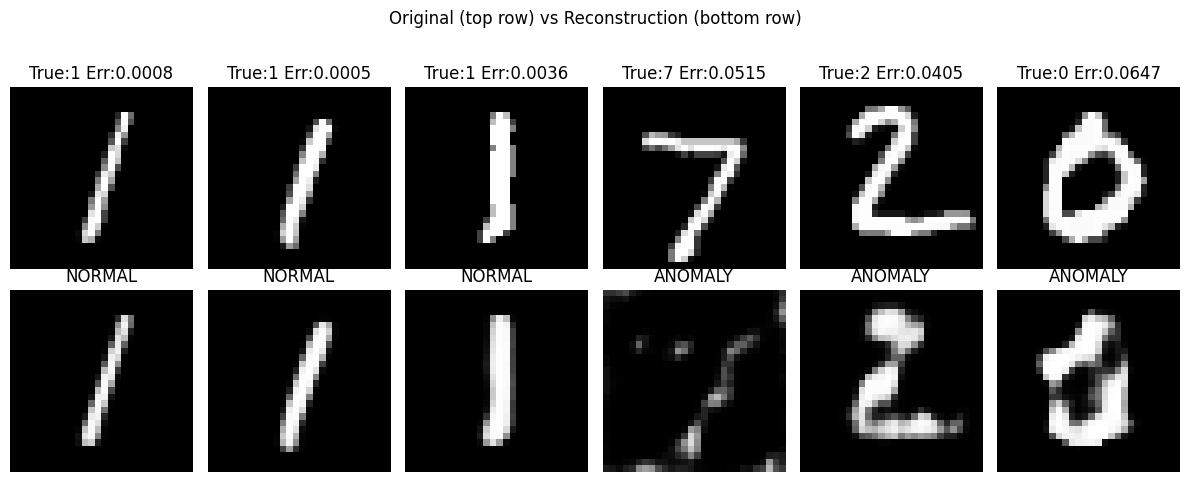

In [10]:
# Visualization: Show original and reconstruction, highlight anomalies vs. normal

is_normal_test = (y_test == normal_class)
n = 6
plt.figure(figsize=(12, 5))
example_idx = np.concatenate([
    np.where(is_normal_test)[0][:n//2],
    np.where(~is_normal_test)[0][:n - n//2]
])

for i, idx in enumerate(example_idx):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idx].reshape(28,28), cmap='gray', vmin=0, vmax=1)
    plt.title(f"True:{y_test[idx]} Err:{test_mse[idx]:.4f}")
    plt.axis('off')
    # reconstruction
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(recon_test[idx].reshape(28,28), cmap='gray', vmin=0, vmax=1)
    flag = "ANOMALY" if anomaly_flags[idx] else "NORMAL"
    plt.title(flag)
    plt.axis('off')

plt.suptitle("Original (top row) vs Reconstruction (bottom row)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()